In [212]:
import numpy as np
import pandas as pd
import datetime as dt
from itertools import combinations
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [213]:
#load two data set
defaults = pd.read_pickle("default_data.pickle")
fininfo = pd.read_pickle("bank financials.pickle")

In [214]:
#to see basic description
print(defaults.head(5))
print(fininfo.head(5))

                         name   cert  \
0              Signature Bank  57053   
1         Silicon Valley Bank  24735   
2           Almena State Bank  15426   
3  First City Bank Of Florida  16748   
4        The First State Bank  14361   

                                            buyer   dflt_date   IDRSSD  \
0                     Signature Bridge Bank, N.A.  2023-03-12  2942690   
1  Deposit Insurance National Bank of Santa Clara  2023-03-10   802866   
2                                     Equity Bank  2020-10-23   224552   
3                       United Fidelity Bank, fsb  2020-10-16   695134   
4                                  MVB Bank, Inc.  2020-04-03   627425   

   default  
0        1  
1        1  
2        1  
3        1  
4        1  
    IDRSSD                        name mutual  trust    rssdhcr        date  \
0   991340             1st Source Bank  Stock      1  1199602.0  2001-12-31   
1   282208       Abington Savings Bank  Stock      0  2521741.0  2001-12-31   

In [215]:
#merge datasets
data = pd.merge(fininfo, defaults[['IDRSSD', 'dflt_date']], on = 'IDRSSD', how = 'left')
data.loc[pd.isnull(data.date), 'date'] = dt.date(2999,12,31)
data['default'] = 0
#sets a default to 1 anytime there is a default occurring 6 to 18 months after the statement date
data.loc[(data.dflt_date >= (data.date + dt.timedelta(days=183))) & 
         (data.dflt_date < (data.date + dt.timedelta(days=548))), 'default'] = 1
print(data.describe())

             IDRSSD         trust       rssdhcr           TII         nonII  \
count  2.394600e+04  23946.000000  2.394600e+04  2.394600e+04  2.394600e+04   
mean   9.625917e+05      0.522217  2.068502e+06  4.007928e+05  1.725831e+05   
std    9.753336e+05      0.499517  1.108190e+06  3.233857e+06  1.730089e+06   
min    5.050000e+02      0.000000  0.000000e+00  8.690000e+02 -5.786320e+05   
25%    3.232040e+05      0.000000  1.123072e+06  2.694925e+04  3.650000e+03   
50%    6.574590e+05      1.000000  1.651032e+06  4.133550e+04  7.339000e+03   
75%    9.628900e+05      1.000000  2.943473e+06  8.620725e+04  1.899125e+04   
max    5.349218e+06      1.000000  5.681262e+06  8.502210e+07  5.267500e+07   

              nonIE          staff        assets          cash    securities  \
count  2.394600e+04   23946.000000  2.394600e+04  2.394600e+04  2.394600e+04   
mean   2.879265e+05    1536.294371  1.515051e+07  9.172908e+05  2.451936e+06   
std    2.474912e+06   11624.123175  1.428123e+08

In [216]:
# removing a troublesome record
data = data[data.deposits > 0]
#create original factors without filter and columns for them, we will filter them later
data['revenue']=data['TII']+data['nonII']
data['expense_to_revenue']=data['nonIE']/data['revenue']
data['loans_to_deposits']=data['loans']/data['deposits']
data['allowance_to_loans']=data['allowance']/data['loans']
factors_original = ['assets','loans','expense_to_revenue','loans_to_deposits','allowance_to_loans']

for i in ['TII', 'nonII', 'staff', 'securities', 'loans','deposits', 'equity','offices']:
    data[i + '_to_assets'] = data[i] / data.assets
    factors_original = factors_original + [i + '_to_assets']
for i in ['cash','TCOs', 'tot_recoveries']:
    data[i + '_to_loans'] = data[i] / data.loans
    factors_original = factors_original + [i + '_to_loans']

In [217]:
#Single Factor Analysis
#for all the factors, unning all of them would be untenable. so explore the corrlation first 
for i in factors_original:
    factors_original_performance = pd.DataFrame({'Factors_original': factors_original,'AUC_Scores': [roc_auc_score(data.default, data[factor])  
                 for factor in factors_original],'corr_with_default':[data[factor].corr(data.default) 
                     for factor in factors_original] })

print(factors_original_performance.sort_values(by='AUC_Scores', ascending=False))

           Factors_original  AUC_Scores  corr_with_default
14            TCOs_to_loans    0.886155           0.227296
4        allowance_to_loans    0.861824           0.140167
5             TII_to_assets    0.755602           0.056043
9           loans_to_assets    0.576869           0.017911
10       deposits_to_assets    0.562657           0.004428
3         loans_to_deposits    0.555574          -0.000461
1                     loans    0.520251          -0.000317
15  tot_recoveries_to_loans    0.496027           0.002898
0                    assets    0.494998           0.000059
2        expense_to_revenue    0.474425           0.012487
13            cash_to_loans    0.436927          -0.005734
12        offices_to_assets    0.430532          -0.016379
7           staff_to_assets    0.407561          -0.021769
8      securities_to_assets    0.369410          -0.032460
6           nonII_to_assets    0.282126          -0.020504
11         equity_to_assets    0.120110          -0.1017

In [218]:
#According to the AUC score, we will choose 
#'TCOs_to_loans','allowance_to_loans', 'TII_to_assets',  'staff_to_assets', 
#'securities_to_assets', 'nonII_to_assets','equity_to_assets' as our factors

In [219]:
#then run the iteration to generate all possible three-factor combinations of the factors
factors=['TCOs_to_loans','allowance_to_loans', 'TII_to_assets',  'staff_to_assets', 
'securities_to_assets', 'nonII_to_assets','equity_to_assets']
factor_combs = list(combinations(factors, 3))

In [220]:
#remove combinations where there is two factors have correlation higher than 50%
for i in factor_combs:
    corr_test=data[list(i)].corr()
    np.fill_diagonal(corr_test.values, 0)
    if np.max(corr_test.values)>0.5:
        factor_combs.remove(i)

In [221]:
print(factor_combs)

[('TCOs_to_loans', 'allowance_to_loans', 'staff_to_assets'), ('TCOs_to_loans', 'allowance_to_loans', 'nonII_to_assets'), ('TCOs_to_loans', 'TII_to_assets', 'staff_to_assets'), ('TCOs_to_loans', 'TII_to_assets', 'securities_to_assets'), ('TCOs_to_loans', 'TII_to_assets', 'nonII_to_assets'), ('TCOs_to_loans', 'TII_to_assets', 'equity_to_assets'), ('TCOs_to_loans', 'staff_to_assets', 'securities_to_assets'), ('TCOs_to_loans', 'staff_to_assets', 'nonII_to_assets'), ('TCOs_to_loans', 'staff_to_assets', 'equity_to_assets'), ('TCOs_to_loans', 'securities_to_assets', 'nonII_to_assets'), ('TCOs_to_loans', 'securities_to_assets', 'equity_to_assets'), ('TCOs_to_loans', 'nonII_to_assets', 'equity_to_assets'), ('allowance_to_loans', 'TII_to_assets', 'staff_to_assets'), ('allowance_to_loans', 'TII_to_assets', 'securities_to_assets'), ('allowance_to_loans', 'TII_to_assets', 'nonII_to_assets'), ('allowance_to_loans', 'TII_to_assets', 'equity_to_assets'), ('allowance_to_loans', 'staff_to_assets', 'secu

In [222]:
#run logit reg model
#create dataframe to store performance of each model
models_performance=pd.DataFrame({'Factors_combs': factor_combs,'R^2':0,'AUC Score':0})
y=data.default
for i in range(len(factor_combs)):
    x=data[list(factor_combs[i])]
    x=sm.add_constant(x) #add constant to variables
    model = sm.Logit(y, x).fit_regularized(method='l1') #fit the model
    models_performance.loc[i,'R^2']=model.prsquared #store pseudo-R-squared for each model
    models_performance.loc[i,'AUC Score']=roc_auc_score(y,model.predict()) #store AUC for each model
print(models_performance)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02769549823094834
            Iterations: 51
            Function evaluations: 52
            Gradient evaluations: 51
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02566349632158854
            Iterations: 68
            Function evaluations: 68
            Gradient evaluations: 68


/var/folders/4v/0vy3yz1525v5z1h309ckrv140000gn/T/ipykernel_16781/2978835941.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.13992280779715616' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  models_performance.loc[i,'R^2']=model.prsquared #store pseudo-R-squared for each model
/var/folders/4v/0vy3yz1525v5z1h309ckrv140000gn/T/ipykernel_16781/2978835941.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.8981470294931311' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  models_performance.loc[i,'AUC Score']=roc_auc_score(y,model.predict()) #store AUC for each model


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.027867975075292355
            Iterations: 54
            Function evaluations: 54
            Gradient evaluations: 54
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02735786983362015
            Iterations: 68
            Function evaluations: 68
            Gradient evaluations: 68
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.026357014831589448
            Iterations: 69
            Function evaluations: 70
            Gradient evaluations: 69
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.022421412283533556
            Iterations: 71
            Function evaluations: 72
            Gradient evaluations: 71
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.027374421379087834
            Iterations: 49
            Fun

In [223]:
#sort the model according to their R^2 and reset index
sorted_models = models_performance.sort_values(by='R^2', ascending=False)
sorted_models =sorted_models_performance.reset_index(drop=True)
print(sorted_models)

                                        Factors_combs       R^2  AUC Score
0    (TCOs_to_loans, TII_to_assets, equity_to_assets)  0.303708   0.934174
1   (TII_to_assets, nonII_to_assets, equity_to_ass...  0.294720   0.937514
2   (TCOs_to_loans, nonII_to_assets, equity_to_ass...  0.283311   0.920508
3   (TCOs_to_loans, securities_to_assets, equity_t...  0.281133   0.922413
4   (TII_to_assets, securities_to_assets, equity_t...  0.279974   0.932212
5   (allowance_to_loans, TII_to_assets, equity_to_...  0.279034   0.930540
6   (TII_to_assets, staff_to_assets, equity_to_ass...  0.270137   0.922887
7   (allowance_to_loans, nonII_to_assets, equity_t...  0.266995   0.922686
8   (TCOs_to_loans, staff_to_assets, equity_to_ass...  0.265414   0.908897
9   (allowance_to_loans, securities_to_assets, equ...  0.261135   0.926054
10  (allowance_to_loans, staff_to_assets, equity_t...  0.245573   0.907899
11  (securities_to_assets, nonII_to_assets, equity...  0.239371   0.913572
12  (staff_to_assets, non

In [224]:
#based on the model,(TCOs_to_loans, TII_to_assets, equity_to_assets) is the best combination
#R^2 =0.303708 and AUC Score = 0.934174
#apply it to predict what would Silicon Valley Bank and Signature Bank happen before its bankruptcy 

In [225]:
y=data.default
x=data[['TCOs_to_loans','TII_to_assets', 'equity_to_assets']]
x=sm.add_constant(x) #add constant to variables
model = sm.Logit(y, x).fit_regularized(method='l1') #fit the model
data['predict_PD']=model.predict()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.022421412283533556
            Iterations: 71
            Function evaluations: 72
            Gradient evaluations: 71


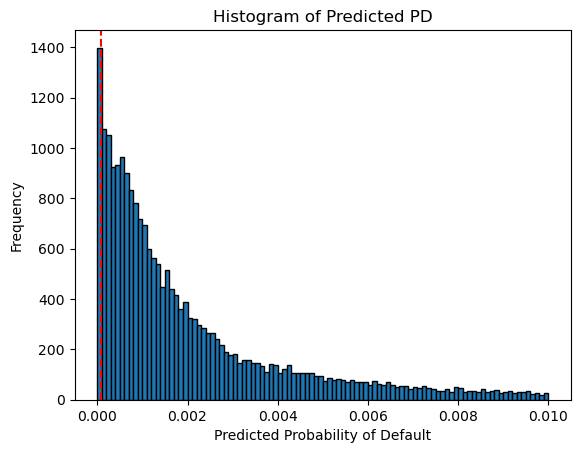

tail= 8.229725003455314e-05


In [226]:
#show the distribution for all the predicted PD and the 95% tail
plt.hist(data['predict_PD'], bins=100, range=(0, 0.01), edgecolor='black')
plt.title('Histogram of Predicted PD')
plt.xlabel('Predicted Probability of Default')
plt.ylabel('Frequency')
plt.axvline(data['predict_PD'].quantile(0.05), color='red', linestyle='--', label=data['predict_PD'].quantile(0.05))
plt.show()
tail=data['predict_PD'].quantile(0.05)
print('tail=',data['predict_PD'].quantile(0.05))

In [227]:
#find lines and id for Silicon Valley Bank and Signature Bank
SVB_id=defaults[defaults['name'].str.contains('silicon', case=False, na=False)].IDRSSD
SB_id=defaults[defaults['name'].str.contains('signature', case=False, na=False)].IDRSSD
print(SVB_id)
print(SB_id)

1    802866
Name: IDRSSD, dtype: int64
0      2942690
169    3264782
Name: IDRSSD, dtype: int64


In [228]:
#get the subdata set for Silicon Valley Bank and Signature Bank
SVB= data.loc[data['IDRSSD']==802866,['name','date','predict_PD']]
SVB['Worse than 95%'] = SVB['predict_PD'].apply(lambda x: 'true' if x > tail else 'not')
print(SVB)

                      name        date  predict_PD Worse than 95%
463    Silicon Valley Bank  2001-12-31    0.002172           true
1133   Silicon Valley Bank  2002-12-31    0.001026           true
1843   Silicon Valley Bank  2003-12-31    0.001136           true
2645   Silicon Valley Bank  2004-12-31    0.013367           true
3557   Silicon Valley Bank  2005-12-31    0.013202           true
4568   Silicon Valley Bank  2006-12-31    0.015183           true
5662   Silicon Valley Bank  2007-12-31    0.021240           true
6797   Silicon Valley Bank  2008-12-31    0.027989           true
7927   Silicon Valley Bank  2009-12-31    0.028886           true
8986   Silicon Valley Bank  2010-12-31    0.025458           true
10010  Silicon Valley Bank  2011-12-31    0.021040           true
11022  Silicon Valley Bank  2012-12-31    0.019441           true
12068  Silicon Valley Bank  2013-12-31    0.024404           true
13157  Silicon Valley Bank  2014-12-31    0.022750           true
14302  Sil

In [229]:
SB = data.loc[(data['IDRSSD'] == 2942690) | (data['IDRSSD'] == 3264782), ['name', 'date', 'predict_PD']]
SB['Worse than 95%'] = SB['predict_PD'].apply(lambda x: 'true' if x > tail else 'not')
print(SB)

                 name        date  predict_PD Worse than 95%
1842   Signature Bank  2003-12-31    0.002395           true
2644   Signature Bank  2004-12-31    0.000653           true
3556   Signature Bank  2005-12-31    0.003115           true
15716  SIGNATURE BANK  2016-12-31    0.001431           true
17238  SIGNATURE BANK  2017-12-31    0.001416           true
18778  SIGNATURE BANK  2018-12-31    0.001473           true
20323  SIGNATURE BANK  2019-12-31    0.001459           true
21937  SIGNATURE BANK  2020-12-31    0.002455           true
23564  SIGNATURE BANK  2021-12-31    0.003978           true


In [230]:
# base on the model, both SVB and Signature bank's predicted PD is worse than 95%
#signaling their bad financial status and forecast their default